dsadasdas

In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

from PIL import Image
import cv2

import random

import os
from pathlib import Path

from data_processing.image_processing import plot_xywhn_annotated_image_from_file, plot_xywhn_annotated_array_from_df
from data_processing.image_augmentation import selected_crop

IMAGES_DIR = "./images"
ANNOTATIONS_DIR = "./annotations"
OUTPUT_DIR = "./output"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def read_yolo_annotation(annotations_path: str):
    try:
        bboxes = pd.read_csv(annotations_path, names=['label', 'x', 'y', 'w', 'h'], sep=' ')
    except:
        return []

    return bboxes[['x', 'y', 'w', 'h', 'label']].values.tolist()

P5760759
[[0.539272, 0.583127, 0.022339, 0.025143, 0.0], [0.565817, 0.627998, 0.020308, 0.037521, 0.0]]


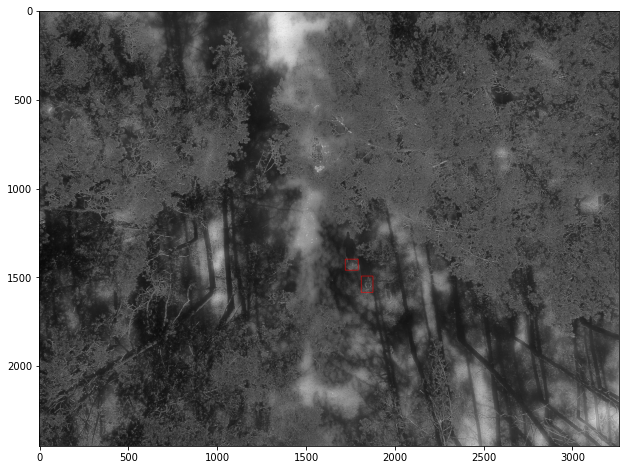

In [15]:
for file in os.listdir(IMAGES_DIR)[30:31]:
    image_path = os.path.join(IMAGES_DIR, file)
    image_filename = Path(file).stem
    annotations_path = f'{ANNOTATIONS_DIR}/{image_filename}.txt'
    if os.path.isfile(image_path):
        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        bboxes = read_yolo_annotation(annotations_path)

print(image_filename)
print(bboxes)
plot_xywhn_annotated_image_from_file(image_path, annotations_path)

[[0.539272, 0.583127, 0.022339, 0.025143, 0.0], [0.565817, 0.627998, 0.020308, 0.037521, 0.0]]
[[0.539272, 0.583127, 0.022339, 0.025143, 0.0], [0.565817, 0.627998, 0.020308, 0.037521, 0.0]]


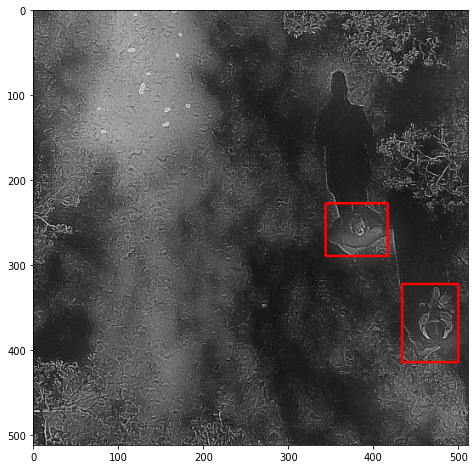

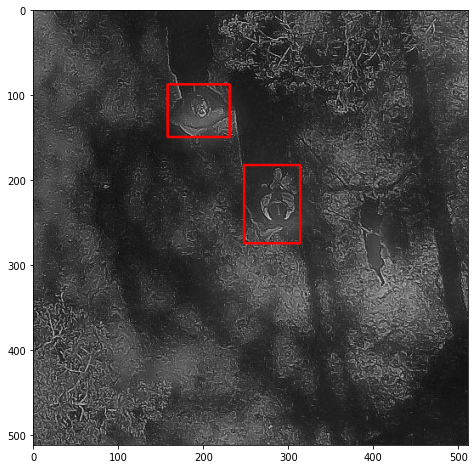

In [16]:
def augmentation_crop(img: np.array, bboxes, new_width=512, new_height=512):
    """
    Crop image for each object

    :param img: image array
    :param bboxes: list with xywhn format annotation
    :param new_width: desired crop width
    :param new_height: desired crop height
    """
    height, width, _ = img.shape

    result_list = []

    for index, row in enumerate(bboxes):
        sample_w = float(row[2]) * width
        sample_h = float(row[3]) * height
        x1, y1 = row[0] * width - sample_w / 2, row[1] * height - sample_h / 2
        # x2, y2 = x1 + sample_w, y1 + sample_h

        dx = random.uniform(max(0, new_width - width + x1), min(new_width - sample_w, x1))
        dy = random.uniform(max(0, new_height - height + y1), min(new_height - sample_h, y1))
        crop_x1 = int(x1 - dx)
        crop_y1 = int(y1 - dy)
        crop_x2 = crop_x1 + new_width
        crop_y2 = crop_y1 + new_height

        print(bboxes)
        transform = A.Compose([
            A.Crop(x_min=crop_x1, y_min=crop_y1, x_max=crop_x2, y_max=crop_y2)
        ], bbox_params=A.BboxParams(format='yolo', min_visibility=0.5))
        transformed = transform(image=img, bboxes=bboxes)

        result_list.append((transformed['image'], transformed['bboxes']))

    return result_list

cropped_images_with_annotation = augmentation_crop(image, bboxes)
for crop_img, crop_annotation in cropped_images_with_annotation:
    plot_xywhn_annotated_array_from_df(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), pd.DataFrame(crop_annotation, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))

# cv2.imwrite(f'{OUTPUT_DIR}/{image_filename}.jpg', transformed_image)

1319
1067
(512, 512, 3)
WARINING: Part of object might be out of cropped image - right side
WARINING: Part of object might be out of cropped image - bottom side
1644
1230
(512, 512, 3)


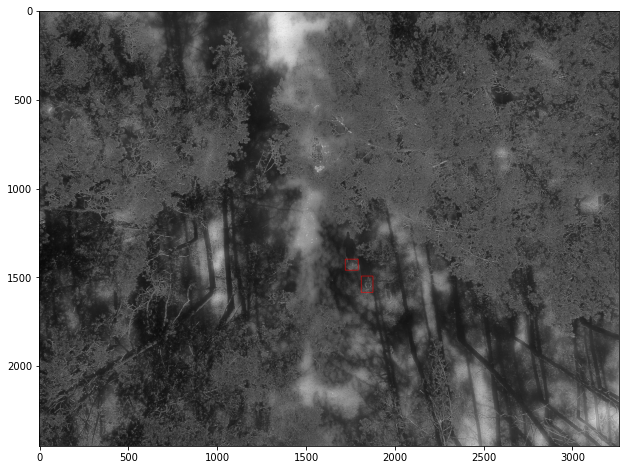

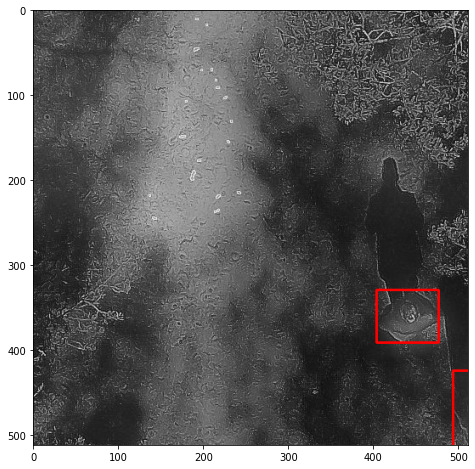

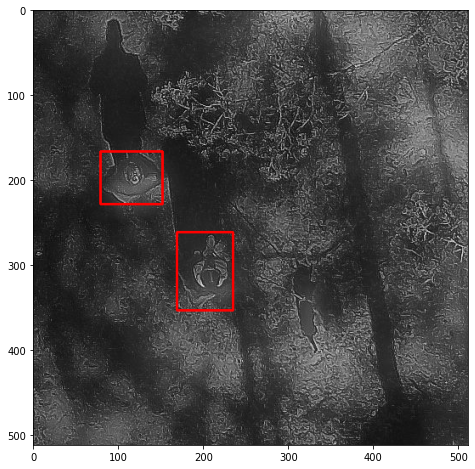

In [96]:
import random

plot_xywhn_annotated_array_from_df(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), pd.DataFrame(bboxes, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))

def crop(img: np.array, df_annotation: pd.DataFrame, new_width=512, new_height=512):
    """
    Crop image for each object

    :param img: image array
    :param df_annotation: dataframe with xywhn format annotation
    :param new_width: desired crop width
    :param new_height: desired crop height
    """
    height, width, _ = img.shape

    result_list = []

    for index, row in df_annotation.iterrows():
        sample_w = float(row['width']) * width
        sample_h = float(row['height']) * height
        x1, y1 = row['xcenter'] * width - sample_w / 2, row['ycenter'] * height - sample_h / 2
        # x2, y2 = x1 + sample_w, y1 + sample_h

        dx = random.uniform(max(0, new_width - width + x1), min(new_width - sample_w, x1))
        dy = random.uniform(max(0, new_height - height + y1), min(new_height - sample_h, y1))
        crop_x1 = int(x1 - dx)
        crop_y1 = int(y1 - dy)

        print(crop_x1)
        print(crop_y1)

        crop_img = img[crop_y1:crop_y1 + new_width, crop_x1:crop_x1 + new_height]
        print(crop_img.shape)
        #crop_img_copy = crop_img.copy()

        crop_annotation = []
        for index, row in df_annotation.iterrows():
            sample_w = float(row['width']) * width
            sample_h = float(row['height']) * height
            x1, y1 = row['xcenter'] * width - sample_w / 2 - crop_x1, row['ycenter'] * height - sample_h / 2 - crop_y1
            x2, y2 = x1 + sample_w, y1 + sample_h
            #cv2.rectangle(crop_img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

            w = sample_w / new_width
            h = sample_h / new_height
            xcenter = (x1 + (x2 - x1) / 2) / new_height
            ycenter = (y1 + (y2 - y1) / 2) / new_width

            if x2 < 0 or x1 > new_width or y2 < 0 or y1 > new_height:
                print("Object out of cropped image - annotation deleted")
                continue

            if x1 < 0 and x2 > 0:
                print("WARINING: Part of object might be out of cropped image - left side")
            if x2 > new_width and x1 < new_width:
                print("WARINING: Part of object might be out of cropped image - right side")
            if y1 < 0 and y2 > 0:
                print("WARINING: Part of object might be out of cropped image - top side")
            if y2 > new_height and y1 < new_height:
                print("WARINING: Part of object might be out of cropped image - bottom side")

            if w > 1:
                print("WARINING: Object might be wider than cropped image")
            if h > 1:
                print("WARINING: Object might be higher than cropped image")

            crop_annotation.append([xcenter, ycenter, w, h, row['label']])

        #plt.figure(figsize=(12, 8))
        #plt.imshow(crop_img_copy)

        result_list.append((crop_img, crop_annotation))

    return result_list


df_bboxes = pd.read_csv(annotations_path, names=['label', 'xcenter', 'ycenter', 'width', 'height'], sep=' ')
cropped_images_with_annotation = crop(image, df_bboxes)

for crop_img, crop_annotation in cropped_images_with_annotation:
    plot_xywhn_annotated_array_from_df(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB), pd.DataFrame(crop_annotation, columns=['xcenter', 'ycenter', 'width', 'height', 'label']))


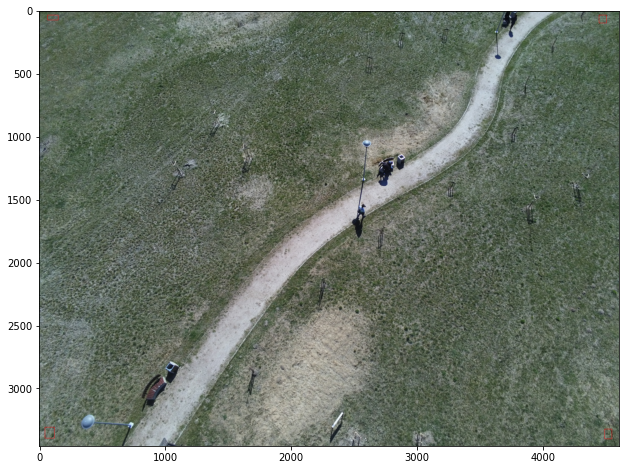

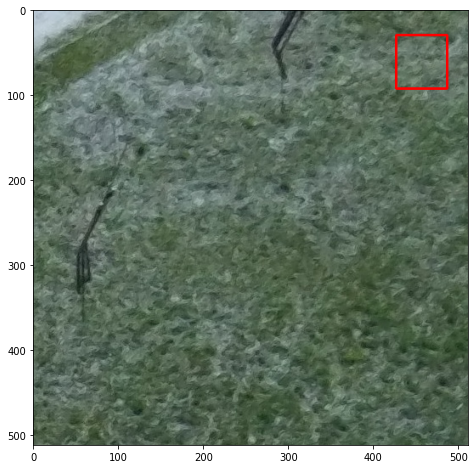

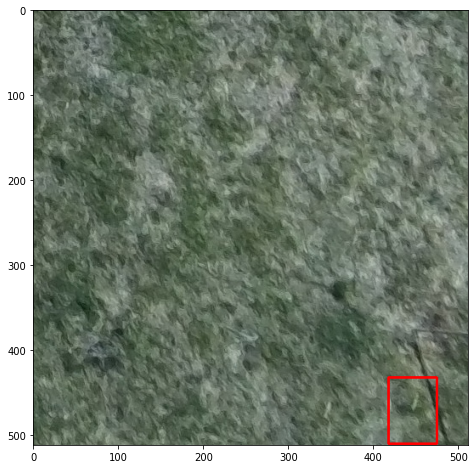

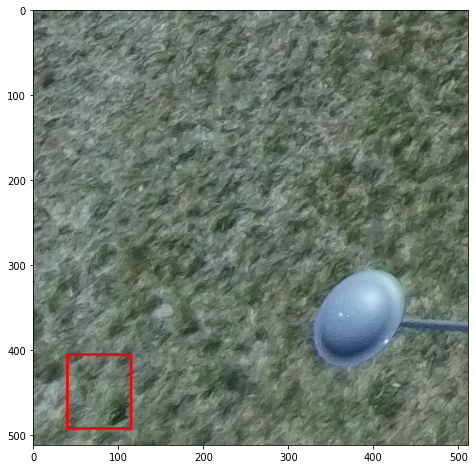

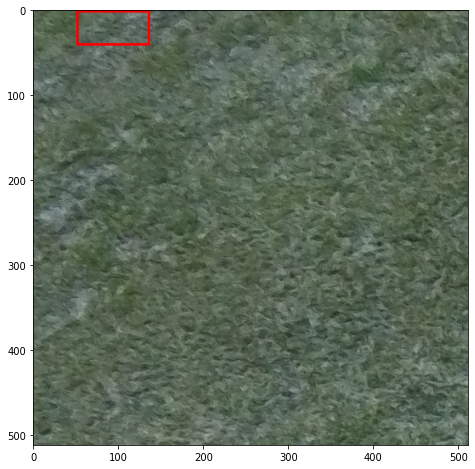

In [27]:
INPUT_IMAGE_PATH = "./images/AAA.jpg"
INPUT_ANNOTATION_PATH = "./annotations/AAA.txt"
OUTPUT_IMAGES_DIR = './output/images'
OUTPUT_ANNOTATIONS_DIR = './output/annotations'

selected_crop(
    image_path=INPUT_IMAGE_PATH,
    annotation_path=INPUT_ANNOTATION_PATH,
    new_width=512,
    new_height=512,
    new_filename='AAA',
    new_image_dir=OUTPUT_IMAGES_DIR,
    new_annotation_dir=OUTPUT_ANNOTATIONS_DIR
)

plot_xywhn_annotated_image_from_file(INPUT_IMAGE_PATH, INPUT_ANNOTATION_PATH)

for image_file, annotation_file in zip(os.listdir(OUTPUT_IMAGES_DIR), os.listdir(OUTPUT_ANNOTATIONS_DIR)):
    image_path = os.path.join(OUTPUT_IMAGES_DIR, image_file)
    annotations_path = os.path.join(OUTPUT_ANNOTATIONS_DIR, annotation_file)

    if os.path.isfile(image_path) and os.path.isfile(annotations_path):
        plot_xywhn_annotated_image_from_file(image_path, annotations_path)